The goal is to reproduce and formalize B-spline curve fitting done in Kappa (java).

In [1]:
import numpy as np
from scipy import interpolate
from scipy.spatial import distance
import matplotlib.pyplot as plt

import sys; sys.path.append("../../")
import pykappa

## Generate the curve

Here we generate a B-spline curve as well as noisy data that will be the input of our curve fitting. We also generate noisy control points we use as initial parameters during fitting.

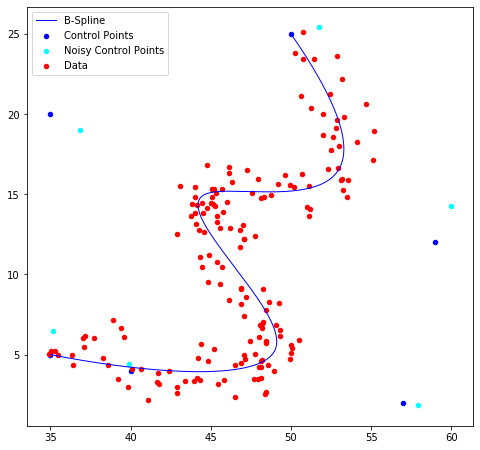

In [2]:
np.random.seed(0)

# Degree of the B-Spline
degree = 3

# Define B-Spline control points
P = np.array([[-5, 15], [-11, 7], [10, 0], [-3, 21], [15, 13], [12, 7]])
P = np.array([[ 50, 25], [ 59, 12], [35, 20], [57, 2], [40, 4],[ 35, 5]])

n = len(P)
n_curves = n - degree  # Because the b-spline is open.

# Generate noisy control points
P_noisy = P + np.random.normal(size=P.shape)

# Compute knot vector: method from Kappa Java's code
# knot_vector_size = 2 * degree + n_curves - 1
# knot_part_1 = [0] * degree
# knot_part_2 = np.arange(degree, knot_vector_size - degree) - degree + 1
# knot_part_3 = [n_curves] * degree
# knot_vector = np.concatenate([knot_part_1, knot_part_2, knot_part_3])
# knot_vector = knot_vector / knot_vector[-1]

# Compute knot vector
knot_vector = np.concatenate(([0] * degree, np.arange(n_curves + 1), [n_curves] * degree))
knot_vector = knot_vector / knot_vector[-1]

# Evaluate B-Spline
n_bspline_point = 500
u = np.linspace(0, 1, n_bspline_point)
bspline = interpolate.BSpline(knot_vector, P, degree, extrapolate=False)
xy = bspline(u)
#tck = tck = (knot_vector, P.T, degree)
#xy = np.array(interpolate.splev(u, tck, ext=0)).T

# Generate noisy data
xy_data = xy + np.random.normal(size=xy.shape)
xy_data = xy_data[::3]
m = xy_data.shape[0]

fig, ax = plt.subplots(figsize=(8, 10))
ax.scatter(P[:, 0], P[:, 1], color='blue', s=20, label='Control Points')
#ax.plot(P[:, 0], P[:, 1], color='blue', label='Control Points')
ax.scatter(P_noisy[:, 0], P_noisy[:, 1], color='cyan', s=20, label='Noisy Control Points')

ax.plot(xy[:, 0], xy[:, 1], color='blue', lw=1, label='B-Spline')
ax.scatter(xy_data[:, 0], xy_data[:, 1], color='red', s=20, label='Data')

ax.set_aspect('equal')
ax.legend(loc='best')

## Compute Footpoints

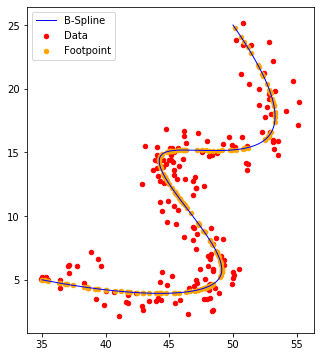

In [3]:
# Get closest points on xy for each data point (xy_data).
footpoint_indices = distance.cdist(xy, xy_data).argmin(axis=0)
xy_footpoint = xy[footpoint_indices]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xy[:, 0], xy[:, 1], color='blue', lw=1, label='B-Spline')
ax.scatter(xy_data[:, 0], xy_data[:, 1], color='red', s=20, label='Data')
ax.scatter(xy_footpoint[:, 0], xy_footpoint[:, 1], color='orange', s=20, label='Footpoint')

ax.set_aspect('equal')
ax.legend(loc='best')

## Linear System of Equations

Define the linear system of equations.

In [4]:
# Generate random weights (can also be set to 1).
weights = np.random.randint(0, 100, size=(xy_data.shape[0],))  # Shape: (m,)

# `X_data` and `Y_data` corresponds to `X` and `Y` in the Java code.
X_data = xy_data[:, 0] * np.sqrt(weights)  # Shape: (m,)
Y_data = xy_data[:, 1] * np.sqrt(weights)  # Shape: (m,)

# `A` corresponds to `vals` in the Java code.
A = np.zeros((m, n))  # Shape: (m, n)
A.shape

(167, 6)

In [14]:
# We evaluate the basis function in order to compute
# the coefficients for each footpoint.

# Extract the corresponding t parameter for the footpoint index.

knot_indices = footpoint_indices / n_bspline_point + degree
knot_indices = knot_indices.astype('int')

raw_t = knot_vector[knot_indices - 1] \
        + (knot_vector[knot_indices] - knot_vector[knot_indices - 1])
t = raw_t * (footpoint_indices % n_bspline_point) / (n_bspline_point - 1)
t = (footpoint_indices % n_bspline_point) / (n_bspline_point - 1)

coefficients = np.zeros((m, n))  # Shape: (m, n)

# Boundary conditions
coefficients[:, 0][t == 0] = 1
coefficients[:, -1][t == 1] = 1

# We now guarantee that t is in between the first and last knot 
# parameter in the B-Spline, excluding end intervals.
# The base case is that the degree 0 coefficient is 1
coefficients[:, knot_indices] = 1

In [15]:
coefficients

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.]])

In [68]:
t

array([0., 0.])

In [12]:
knot_indices